# Green Coverage and Accessibility Analysis in Valencia

In this project, I explore the availability and accessibility of green zones in Valencia by analyzing spatial data related to census tracts and green areas. My primary focus is to evaluate the distribution of green spaces and assess their accessibility.

**Data Sources**

The data for this analysis is sourced from:
- **Census and demographic data**: Retrieved from the [Instituto Nacional de Estadística](https://www.ine.es).
- **Green zones and census tracts geospatial data**: Accessed via the [Geo Portal del Ayuntamiento de Valencia](https://valencia.opendatasoft.com/pages/home/) through an API.

## Methodology

The analysis is structured into several key stages:

1. **Exploratory Green Coverage Analysis**
I begin by assessing the per capita availability of green space. This metric helps to determine if there is adequate green space relative to the population density in each census tract, highlighting areas where additional green spaces might be necessary.

2. **Accessibility Analysis**
For measuring accessibility, I utilize the 2-Step Floating Catchment Area (2SFCA) method, which considers several factors:

 - Distances: I calculate the Manhattan distances between census tracts and green zones.
 - Green Zone Areas: Larger green spaces receive higher accessibility scores.
 - Catchment Area: I define accessible areas using a 500-meter isochrone.
 - Population: I include the population of census tracts to evaluate how many residents benefit from green spaces within the defined area.

3. **Spatial Autocorrelation**:

   - **Global Spatial Autocorrelation**: To understand overall spatial trend I apply global measures, such as Moran statistic.
   - **Local spatial autocorrelation**: To understand patterns of green coverage, I apply hot spot and cold spot analysis, which helps identify clusters of census tracts with high or low green coverage.

In [4]:
# Import libraries

# API requests
import requests

# Data manipulation
import pandas as pd  
import geopandas as gpd  
import pickle 
import numpy as np

# Geometries manipulation
from shapely.geometry import shape, Polygon, MultiPolygon, Point, LineString  

# Visualization
import matplotlib.pyplot as plt  
import seaborn as sns  
import contextily as ctx  

# Spatial analysis
from pysal.lib import weights  
from mgwr.gwr import GWR  
from mgwr.sel_bw import Sel_BW  
from esda.moran import Moran  
import esda  
from splot import esda as esdaplot  

# Statistical analysis
from scipy.stats import norm, shapiro  

# System
from IPython.display import display, HTML
import os  

# Preprocessing
In this section, I retrieve and process spatial data from Valencia's open data API, including green zones and district boundaries. The data undergoes preprocessing by converting geometries into Shapely objects and filtering out irrelevant districts and data categories. Specifically, green zones categorized as "Acompañamiento Viario" and "Bulevar" are excluded from the analysis. Additionally, I filter the census sections, excluding those from the rural districts of 'Els Pobles' due to their low population density, as recommended by the Special Plan for Urban Quality Guidelines by AUMSA.

The processed data is then integrated with other socio-economic indicators such as population density, average income, unemployment rates, and education levels. After merging and renaming key fields for consistency, the census tracts and green zones are visualized on the map.

Valencia's central structure comprises 560 census sections organized into 19 districts. The preprocessing steps included merging various data sources to create a comprehensive dataset, integrating population data with socio-economic indicators such as average income, education levels, and demographics. I also calculated a new variable for population density and standardized district names for consistency. Finally, the processed data is saved as GeoJSON files for further use or analysis.

Green Zones GeoDataFrame extracted successfully
Districts GeoDataFrame extracted succesfully
EPSG:25830


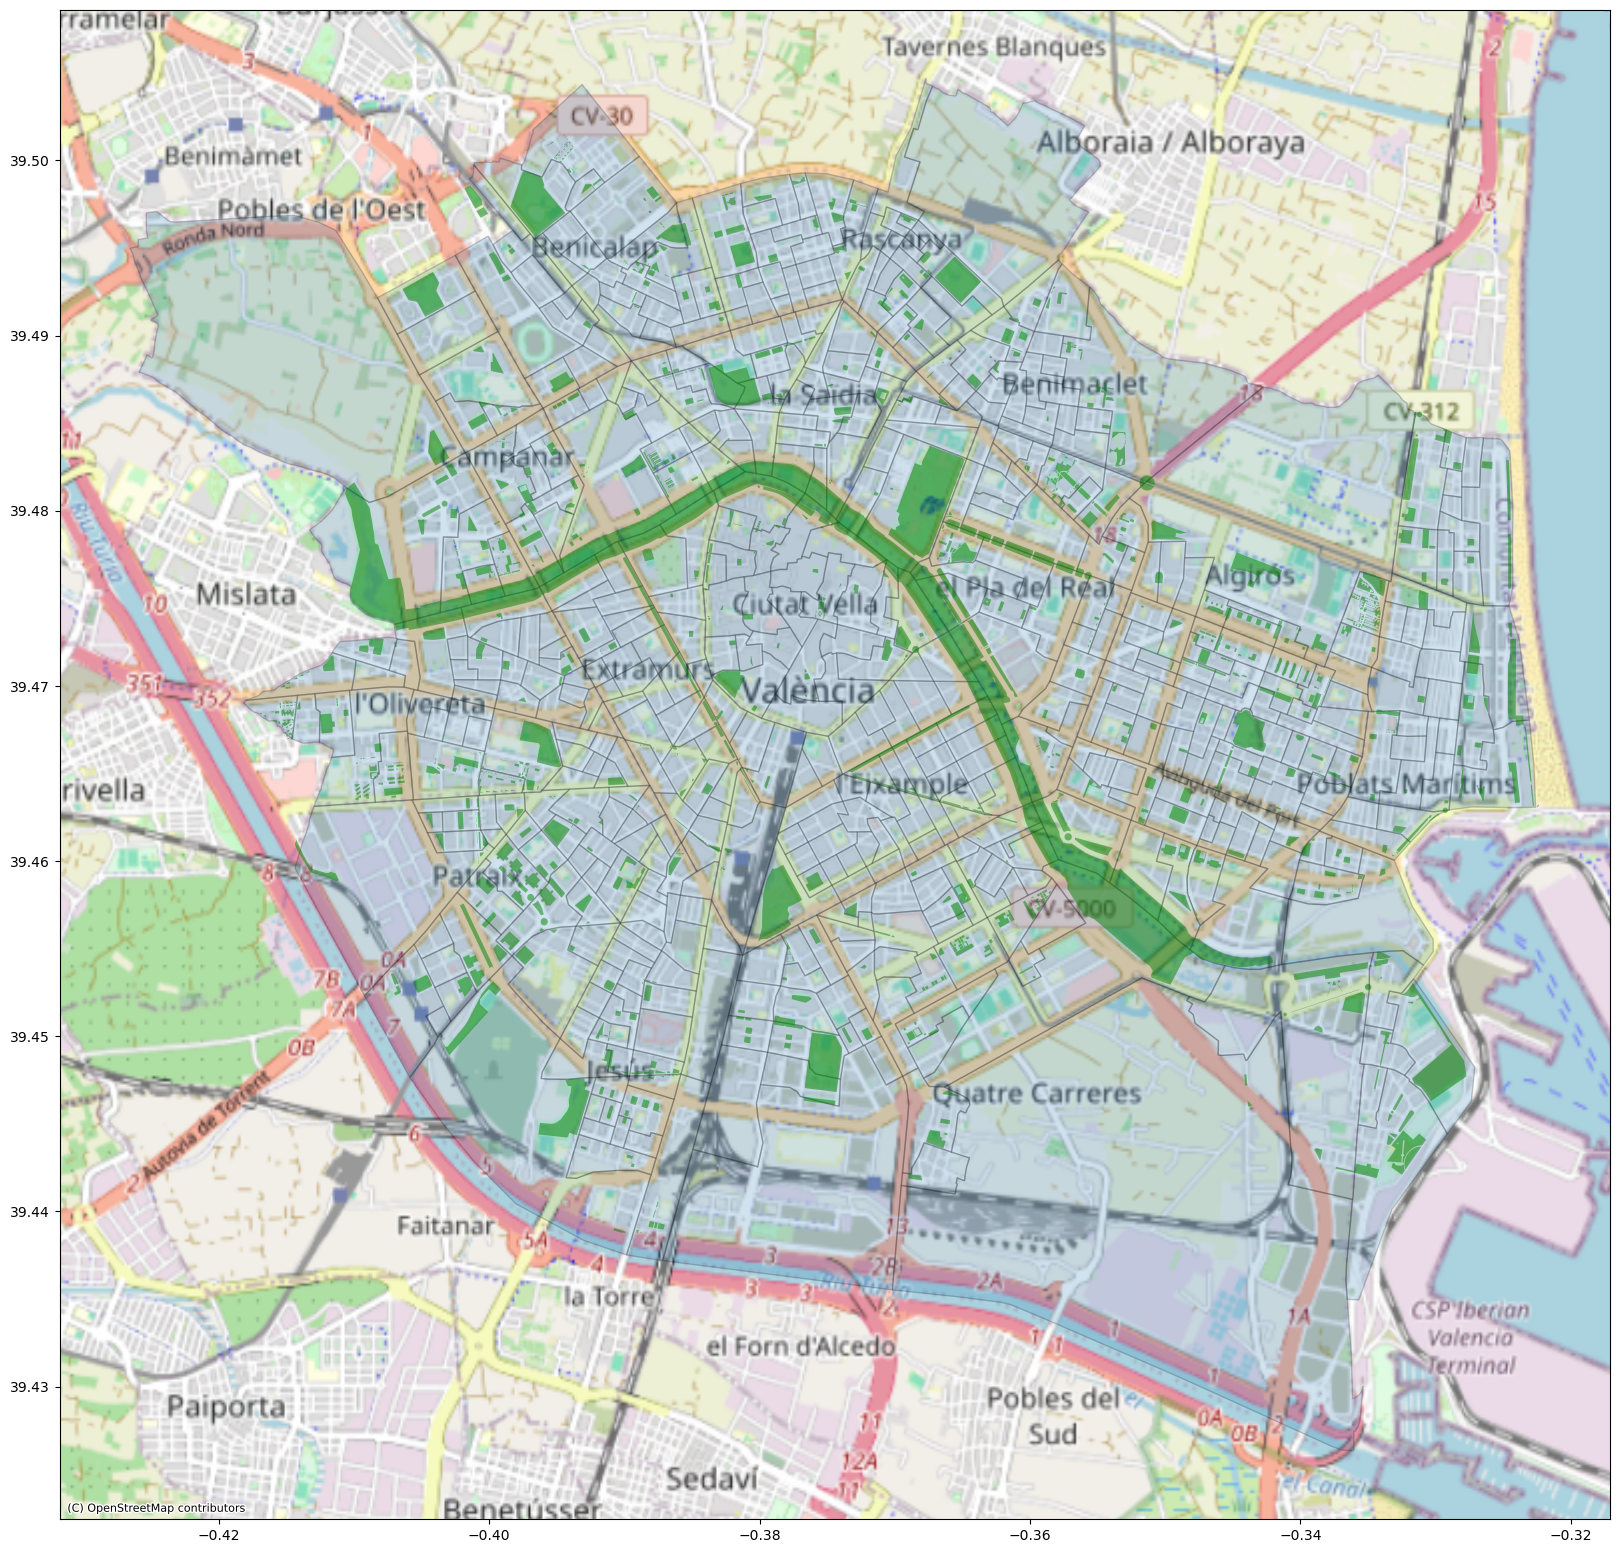

The Green Zones GeoDataFrame contains 434 polygons, each representing a green area categorized into one of three typologies: Jardines Barrio Plaza, Parques Urbanos, Jardines Especial Protección, Unknown

The Census tracts GeoDataFrame contains 560 polygons with 14 features.


coddistrit     CODSECC   population  st_shape_area  population_density  \
count  560.000000  560.000000   560.000000   5.600000e+02          560.000000   
mean     8.594643   22.246429  1333.998214   8.776598e+04            0.031918   
std      4.433363   13.864666   425.465270   2.819453e+05            0.016584   
min      1.000000    1.000000   603.000000   9.575815e+03            0.000152   
25%      5.000000   11.000000  1008.000000   2.909789e+04            0.019784   
50%      9.000000   21.000000  1266.000000   4.183453e+04            0.031612   
75%     12.000000   32.000000  1587.000000   6.794383e+04            0.041904   
max     16.000000   57.000000  3090.000000   5.264195e+06            0.110607   

          age_avg  pct_foreigners  education_avg  pct_unemployed         Vm2  \
count  560.000000      560.000000     560.000000      560.000000  560.000000   
mean    45.170125        0.136744       3.077482        0.166644  418.604899   
std      2.761848        0.064944       0.260910        0.059017  118.348333   
min     33.150000        0.029600       2.550000        0.053400  177.229364   
25%     43.710000        0.089850       2.880000        0.128700  343.679839   
50%     45.470000        0.126950       3.040000        0.161000  390.680811   
75%     46.885000        0.170225       3.290000        0.194850  467.105220   
max     56.360000        0.544900       3.660000        0.407700  929.741397   

         income_avg  
count    560.000000  
mean   35691.523214  
std    11091.875854  
min    16640.000000  
25%    28129.750000  
50%    32831.500000  
75%    39814.750000  
max    88769.000000

In [6]:
%run src/load_and_process.py

# Green Coverage
This section aims to assess the green area coverage in the city, comparing it across different zones and districts, and calculating the green space available per person in each area. The workflow includes spatial data processing, aggregation of green area coverage, and visualizing the results. In this section we will:
1. Convert park areas to hectares and summarize by type.
3. Calculate total green area and percentage of coverage relative to the municipal area.
4. Link parks to census tracts and aggregate green area and population by zones.
5. Create bar plots to show green coverage per person with WHO benchmarks.

1. **Calculating Green Area by Category**
The total area for each green zone is calculated in hectares (ha) by converting the shape area from square meters. The green zones are grouped by their categories (e.g., parks, gardens) to summarize the total green area in each category. This provides insights into the distribution of different types of green areas across the city.

In [11]:
# Convert to crs epsg=25830
green_zones = green_zones.to_crs(epsg=25830)
census_tracts = census_tracts.to_crs(epsg=25830)

# Convert the area from sqm to ha
green_zones['area_ha'] = green_zones['st_area_shape'] / 10000  # 1 ha = 10,000 sqm

# Group by category and sum
area_by_category = green_zones.groupby('tipologia')['st_area_shape'].sum().reset_index()

# Convert total area to ha
area_by_category['area_ha'] = area_by_category['st_area_shape'] / 10000

# 2 decimals
area_by_category['area_ha'] = area_by_category['area_ha'].apply(lambda x: f'{x:,.2f} ha')

print("\n")
print('Area by category') 
display(area_by_category[['tipologia', 'area_ha']])
print("\n")



Area by category


tipologia    area_ha
0         Jardines Barrio Plaza  123.56 ha
1  Jardines Especial Protección   37.08 ha
2               Parques Urbanos  223.32 ha

These findings provide valuable insights into the distribution of green spaces across the city, indicating a strong emphasis on urban parks, which comprise the largest portion of the total green area at 223.32 ha. This highlights the city's commitment to providing accessible recreational spaces for residents. In contrast, protected gardens and Jardines Barrio Plaza occupy smaller areas, with 37.08 ha and 123.56 ha, respectively.

2. **Total Green Coverage in the City**
The total area of green zones in the city is computed in square kilometers. This is compared to the overall municipal area, also calculated from the census data, to determine the percentage of green coverage in the city. This percentage represents the ratio of green space relative to the total urban area.

$$ \% \text{ of Green Cover} = \frac{\text{Green cover in sq km}}{\text{Municipal area in sq km}} \times 100 $$

In [15]:
# Calculate total green coverage in sq.km
total_green_area_sqm = green_zones['st_area_shape'].sum()
total_green_area_sqkm = total_green_area_sqm/ 1_000_000
print(f'Total Green Coverage: {total_green_area_sqkm:,.2f} sqkm')
print("\n")

# Calculate Municipal area in sq.km
mun_area_sqm = census_tracts['st_shape_area'].sum()
mun_area_sqkm = mun_area_sqm/1_000_000
print(f'Total Municipal Area: {mun_area_sqkm:,.2f} sqkm')
print("\n")

# Calculate % of the green cover in the city
green_cover_pct = (total_green_area_sqkm/mun_area_sqkm)*100
print(f'Percentage of green cover in the city: {green_cover_pct:,.2f} %')

Total Green Coverage: 3.84 sqkm


Total Municipal Area: 49.15 sqkm


Percentage of green cover in the city: 7.82 %


These findings indicate that while there is a dedicated green space within the city, it constitutes only a small fraction of the total municipal area. At 7.82%, the percentage of green cover suggests potential areas for improvement in urban planning to enhance the availability of green spaces for residents. This percentage also serves as a benchmark for assessing the city's sustainability goals and the well-being of its inhabitants.

3. **Green Area and Population by Zone**

To associate each green zone with the census section it intersects a spatial join is performed between the parks and census tracts. This allows the analysis to evaluate how green areas are distributed across the city’s population.

The analysis then aggregates the green area coverage for each city zone by summing the areas of green zones within each zone. Similarly, population data is aggregated by zone, and the green space available per person is calculated. This is an important metric to measure urban green space accessibility for residents.

A bar plot visualize the green cover per person by zone. The plot includes two reference lines: one indicating the World Health Organization (WHO) ideal recommendation of 50 square meters per person and another indicating the minimum recommendation of 9 square meters per person. These benchmarks help to identify areas where green space provision falls below global standards.

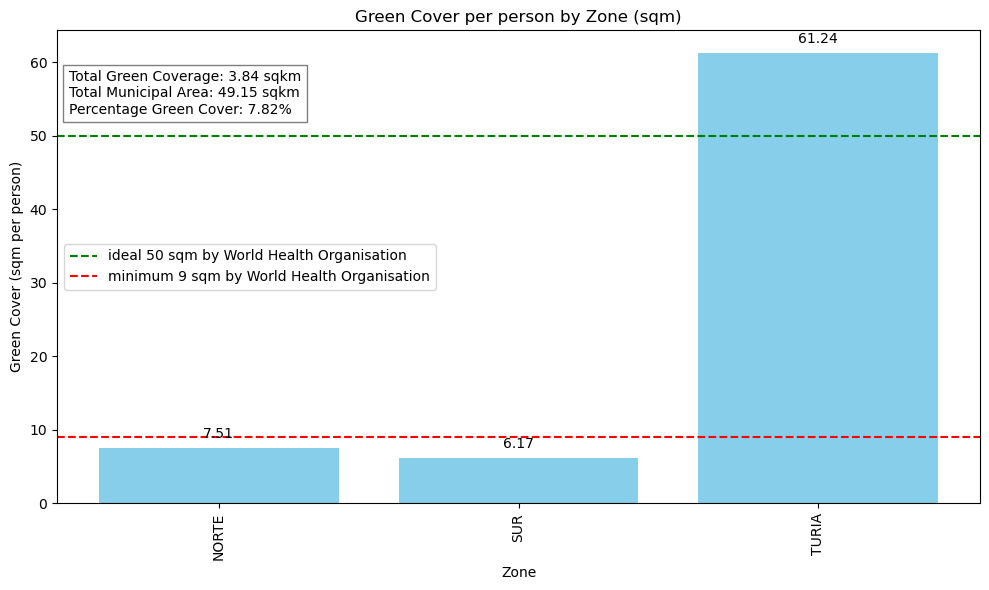

In [19]:
# Spatial join btw green_zones and census
green_zones_with_census = gpd.sjoin(green_zones, census_tracts, how="left", predicate="intersects")

# Verify green_zones per section
green_zones_per_section = green_zones_with_census.groupby('coddistsecc').size()

# Aggregate the green area per zone. Group by the 'zona' column from green_zones and sum the green area
green_area_per_zone = green_zones_with_census.groupby('zona')['st_area_shape'].sum().reset_index()
green_area_per_zone['green_area_ha'] = green_area_per_zone['st_area_shape'] / 10000
green_area_per_zone['green_area_ha'] = green_area_per_zone['green_area_ha'].apply(lambda x: f'{x:,.2f} ha')

# Aggregate population per zone
population_per_zone = green_zones_with_census.groupby('zona')['population'].sum().reset_index()

data_by_zone = pd.merge(green_area_per_zone, population_per_zone, on='zona')

data_by_zone['sqm_per_person'] = data_by_zone['st_area_shape']/data_by_zone['population']

# Plot Coverage by Zone
plt.figure(figsize=(10,6))
bars = plt.bar(data_by_zone['zona'], data_by_zone['sqm_per_person'], color='skyblue')

plt.axhline(y=50, color='green', linestyle='--', label='ideal 50 sqm by World Health Organisation')
plt.axhline(y=9, color='red', linestyle='--', label='minimum 9 sqm by World Health Organisation')

# Add text for area by category
for i, (zona, sqm) in enumerate(zip(data_by_zone['zona'], data_by_zone['sqm_per_person'])):
    plt.text(i, sqm + 1, f'{sqm:,.2f}', ha='center', va='bottom', fontsize=10)

# Add textbox with total green coverage and municipal 
plt.text(-0.5, 53,
         f'Total Green Coverage: {total_green_area_sqkm:,.2f} sqkm\n'
         f'Total Municipal Area: {mun_area_sqkm:,.2f} sqkm\n'
         f'Percentage Green Cover: {green_cover_pct:,.2f}%',
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Zone')
plt.ylabel('Green Cover (sqm per person)')
plt.title("Green Cover per person by Zone (sqm)")

plt.xticks(rotation=90)

plt.legend()

plt.tight_layout()
plt.show()

**Zone Norte**: Residents have access to **7.51 sqm** of green space per person, which is below the minimum recommended level.

**Zone Sur**: This zone shows an even lower access rate, with **6.17 sqm** of green space per person, also falling short of the minimum recommendation.

**Zone of the River Park Turia**: In stark contrast, this zone offers an impressive **61.24 sqm** of green space per person, significantly exceeding the ideal recommendation.

These findings highlight significant disparities in green space accessibility among various zones. The notably low percentages in Zones Norte and Sur underscore the urgent need to enhance green infrastructure in these areas to meet global standards, ultimately improving residents' quality of life.

4. **Green Area and Population by District**

Next, I aggregated the green area and population data by administrative districts. This analysis mirrors the zone-level calculations, deriving the green space per person for each district, providing further insights into green space distribution.

I created a second bar plot to illustrate green cover per person across districts, again comparing the results against WHO standards.

The plot reveals significant differences in accessibility, emphasizing the need for targeted improvements in districts with low green coverage, particularly in Rascanya and Benimaclet.

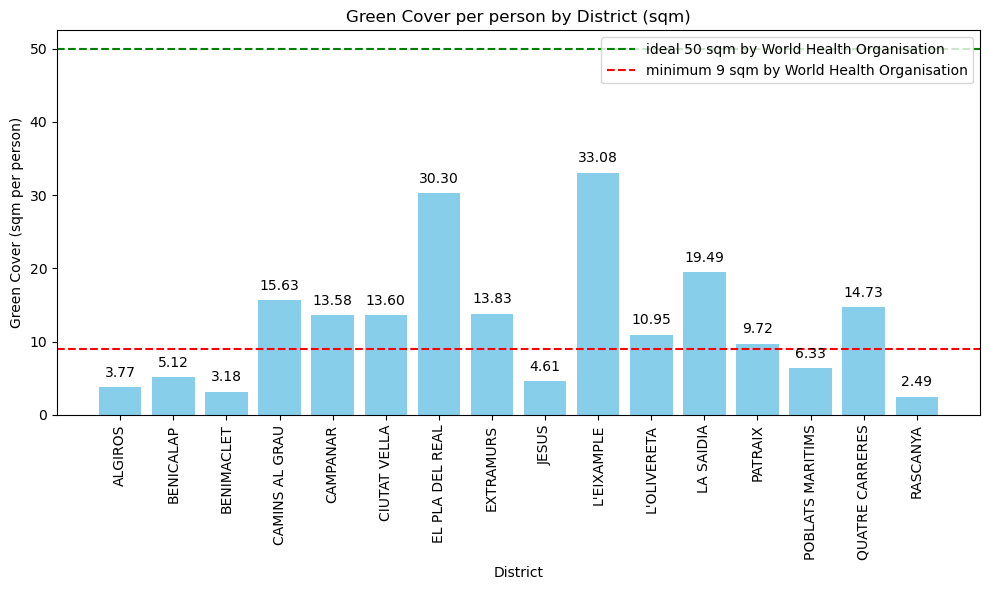

In [23]:
# Aggregate the green zones per District
green_area_per_district = green_zones_with_census.groupby('dm_right')['st_area_shape'].sum().reset_index()
green_area_per_district['green_area_ha'] = green_area_per_district['st_area_shape'] / 10000
green_area_per_district['green_area_ha'] = green_area_per_district['green_area_ha'].apply(lambda x: f'{x:,.2f} ha')

population_per_district = green_zones_with_census.groupby('dm_right')['population'].sum().reset_index()

data_by_district = pd.merge(green_area_per_district, population_per_district, on='dm_right')
data_by_district['sqm_per_person'] = data_by_district['st_area_shape']/data_by_district['population']

data_by_district = data_by_district.rename(columns = {'dm_right' : 'dm'})

# Barplot Green covergae by District
plt.figure(figsize=(10,6))
bars = plt.bar(data_by_district['dm'], data_by_district['sqm_per_person'], color='skyblue')

plt.axhline(y=50, color='green', linestyle='--', label='ideal 50 sqm by World Health Organisation')
plt.axhline(y=9, color='red', linestyle='--', label='minimum 9 sqm by World Health Organisation')

# Add text for area by category
for i, (zona, sqm) in enumerate(zip(data_by_district['dm'], data_by_district['sqm_per_person'])):
    plt.text(i, sqm + 1, f'{sqm:,.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('District')
plt.ylabel('Green Cover (sqm per person)')
plt.title("Green Cover per person by District (sqm)")

plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Accessibility Index Calculation Using the 2SFCA Method

The Two-Step Floating Catchment Area (2SFCA) method is a widely adopted technique for measuring accessibility to services, such as green zones. In this section, I outline how I calculate the accessibility index using the 2SFCA method, specifically tailored to evaluate access to green zones.

### Overview of the 2SFCA Method
The 2-Step Floating Catchment Area (2SFCA) method is a spatial accessibility analysis technique that evaluates the relationship between supply centers (e.g., green zones) and demand centers (e.g., census tracts) in a given area. The method consists of several key steps:

 - **Distance Calculation**: Determine the distances between each supply center and demand center. This step is crucial for understanding the spatial relationship between green zones and the populations they serve. 
- **Distance Decay Function**: Calculate weights for these distances using a distance decay function, which reflects the principle that accessibility decreases as distance increases.
- **Step1: Supply-to-Demand Ratio (R_i)**: Compute the supply-to-demand ratio for each demand center. This ratio assesses how well the supply centers can meet the needs of the population in the corresponding census tracts.
- **Accessibility Index (A_j**): Finally, calculate the accessibility index for each demand center, which provides a quantitative measure of how accessible the supply centers are to the population in the census tracts.
Through these steps, the 2SFCA method helps identify areas with varying levels of accessibility to green zones, allowing for better planning and resource allocation.

### Distance Calculations

I calculate the distances between each census tract centroid and the nearest point in each green zone using Manhattan distance:

$$d_{ij} = |x_i - x_j| + |y_i - y_j|$$

Where:
- $ d_{ij} $ is the Manhattan distance between census tract $ i $ and green zone $ j $.
- $ (x_i, y_i) $ are the coordinates of the census tract centroid.
- $ (x_j, y_j) $ are the coordinates of the green zone point.

In [26]:
# Calculate centroid for census tracts
census_tracts['centroid'] = census_tracts.geometry.centroid

# Distances calculations
# File to save precomputed distances
distances_file = 'precomputed_distances.pkl'

# Function to calculate Manhattan distances
def manhattan_distance(p1, p2):
    """Calculates Manhattan distance between two points: p1 and p2."""
    return abs(p1.x - p2.x) + abs(p1.y - p2.y)

# Load or calculate distances
if os.path.exists(distances_file):
    print("Loading precomputed distances...")
    with open(distances_file, 'rb') as f:
        distances = pickle.load(f)
else:
    print("Calculating distances...")
    # Calculate distances if file does not exist
    distances = {}

    for idx_sec, row_sec in census_tracts.iterrows():
        centroid_sec = row_sec['centroid']
        distances[idx_sec] = {}
        
        for idx_area, row_area in green_zones.iterrows():
            distancias_vertices = []
            
            if isinstance(row_area.geometry, Polygon):
                for point in row_area.geometry.exterior.coords:
                    distancia = manhattan_distance(centroid_sec, Point(point))
                    distancias_vertices.append(distancia)
                    
            elif isinstance(row_area.geometry, MultiPolygon):
                for polygon in row_area.geometry.geoms:
                    for point in polygon.exterior.coords:
                        distancia = manhattan_distance(centroid_sec, Point(point))
                        distancias_vertices.append(distancia)
            
            if distancias_vertices:  # Only store if vertices were found
                distances[idx_sec][idx_area] = min(distancias_vertices)
    
    # Save the computed distances to file
    with open(distances_file, 'wb') as f:
        pickle.dump(distances, f)
    print(f"Distances saved to {distances_file}")

Calculating distances...
Distances saved to precomputed_distances.pkl


# Weights Calculations

A distance-decay function assigns weights based on proximity, with the Gaussian distance-decay function defined as:

$$
G(d_{ij}, d_0) = \begin{cases}
\frac{\exp\left(-\frac{1}{2}\left(\frac{d_{ij}}{d_0}\right)^2\right) - \exp\left(-\frac{1}{2}\right)}{1 - \exp\left(-\frac{1}{2}\right)} & \text{if } d_{ij} \leq d_0 \\
0 & \text{if } d_{ij} > d_0
\end{cases}
$$

Where:
- $ d_0 $ is a threshold distance (e.g., 500 meters) beyond which the weight is zero.


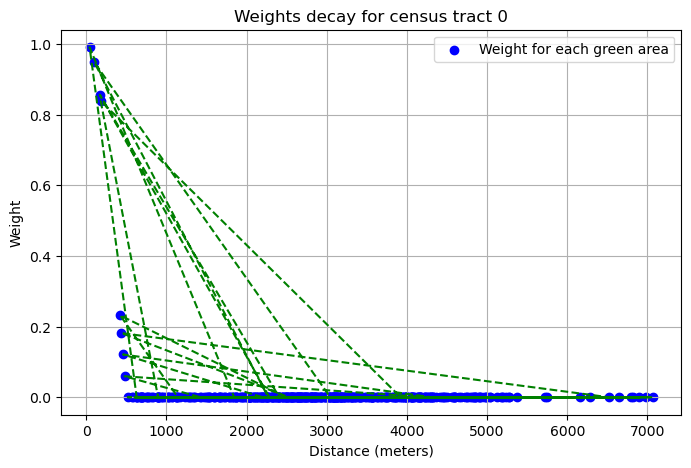

In [28]:
# Weights Calculations
# Define Gaussian distance-decay function
def G(d_ij, d_0=500):
    """Distance-decay function G(d_ij, d_0) based on a Gaussian distribution."""
    if d_ij <= d_0:
        return (np.exp(-0.5 * (d_ij / d_0)**2) - np.exp(-0.5)) / (1 - np.exp(-0.5))
    else:
        return 0

# Calculate weights for each census tract and green area
d_0 = 500  # Max threshold for distance in meters
weights = {}

for sec_idx, dist_dict in distances.items():
    weights[sec_idx] = {area_idx: G(d_ij, d_0) for area_idx, d_ij in dist_dict.items() if d_ij <= d_0}

# Plot distances vs weights for one census tract
sec_idx = 0  # Change to desired index
distances_for_tract = distances[sec_idx]
weights_for_tract = {area_idx: G(d_ij, d_0=500) for area_idx, d_ij in distances_for_tract.items()}

distances_list = list(distances_for_tract.values())
weights_list = list(weights_for_tract.values())

plt.figure(figsize=(8, 5))
plt.scatter(distances_list, weights_list, color='blue', label='Weight for each green area')
plt.plot(distances_list, weights_list, color='green', linestyle='--')
plt.title(f"Weights decay for census tract {sec_idx}")
plt.xlabel("Distance (meters)")
plt.ylabel("Weight")
plt.grid(True)
plt.legend()
plt.show()

### Step 1: Supply-to-Demand Ratio Calculation

The supply-to-demand ratio $ R_i $ for each green zone is computed using the formula:

$$
R_i = \frac{S_i}{\sum_{j \in J_i} P_j \cdot w_{ij}}
$$

Where:
- $ S_i $ is the area of the green zone $ i $.
- $ P_j $ is the population of census tract $ j $.
- $ w_{ij} $ is the weight assigned to census tract $ j $ based on its distance to green zone $ i $.
- $ J_i $ is the set of all census tracts that influence green zone $ i $.

In [30]:
# Calculate supply-to-demand ratio (R_i) for green zones
# %% [fold]
S_i = green_zones.geometry.area.tolist()  # Green zone areas
P_j = census_tracts['population'].tolist()  # Population of census tracts

def Ri(S_i, weights, P_j):
    """Calculate supply-to-demand ratio for green areas (R_i)."""
    total_weighted_population = sum(weight * P_j[idx] for idx, weight in weights.items())
    return S_i / total_weighted_population if total_weighted_population != 0 else 0

R_i = []
for area_idx, s in enumerate(S_i):
    area_weights = {sec_idx: weights[sec_idx][area_idx] for sec_idx in weights if area_idx in weights[sec_idx]}
    
    if area_weights:
        population_influence = {sec_idx: P_j[sec_idx] for sec_idx in area_weights.keys()}
        ratio = Ri(s, area_weights, population_influence)
        R_i.append(ratio)
    else:
        R_i.append(0)

### Step 2: Accessibility Index Calculation

The final step is to calculate the accessibility index $ A_j $ for each census tract:

$$
A_j = \sum_{i \in I_j} R_i \cdot w_{ij}
$$

Where:
- $ R_i $ is the supply-to-demand ratio for green zone $ i $.
- $ w_{ij} $ is the weight for census tract $ j $ based on the distance to green zone $ i $.
- $ I_j $ is the set of all green zones that influence census tract $ j $.

### Normalization

The calculated accessibility index values are normalized using Min-Max scaling:

$$
\text{Normalized } A_j = \frac{A_j - A_{\text{min}}}{A_{\text{max}} - A_{\text{min}}}
$$

Where:
- $ A_{\text{min}} $ and $ A_{\text{max}} $ are the minimum and maximum accessibility values across all census tracts.

In [32]:
# Calculate A_j for each census tract (Accessibility to green zones)
# %% [fold]
def Aj(weights, ratios):
    """Calculate A_j, accessibility for a given census tract."""
    weighted_ratios = [weight * ratio for weight, ratio in zip(weights, ratios)]
    return sum(weighted_ratios)

A_j_values = []

census_unique = list(census_tracts.index)

dw_df = []
for sec_idx, area_distances in distances.items():
    for area_idx, dist in area_distances.items():
        dw_df.append({
            'Seccion': sec_idx,
            'Green_Zone': area_idx,
            'Distancia': dist,
            'Peso_G': G(dist, d_0)  # Use G function for weight calculation
        })
dw_df = pd.DataFrame(dw_df)

for seccion in census_unique:
    distance_seccion = dw_df[dw_df['Seccion'] == seccion]
    ratios = [R_i[area_idx] for area_idx in distance_seccion['Green_Zone']]
    G_weights = distance_seccion['Peso_G'].tolist()
    A_j = Aj(G_weights, ratios)
    A_j_values.append(A_j)

census_tracts['acces_raw'] = A_j_values
# %% [unfold]

from sklearn.preprocessing import MinMaxScaler

# Normalize 'Accesibility' btw 0 y 1 using Min-Max Scaling
scaler = MinMaxScaler()
census_tracts['acces_norm'] = scaler.fit_transform(census_tracts[['acces_raw']])

Finally, I visualize the normalized accessibility index on a map, highlighting variations in accessibility to green zones across different census tracts.

This map employs a color gradient ranging from light green (low accessibility) to dark green (high accessibility), clearly showing that areas with higher accessibility are primarily located along the Turia river park.

While this initial observation is insightful, I plan to conduct a more detailed spatial analysis in upcoming sections, focusing on both global and local correlations. This will deepen my understanding of accessibility dynamics related to green zones.

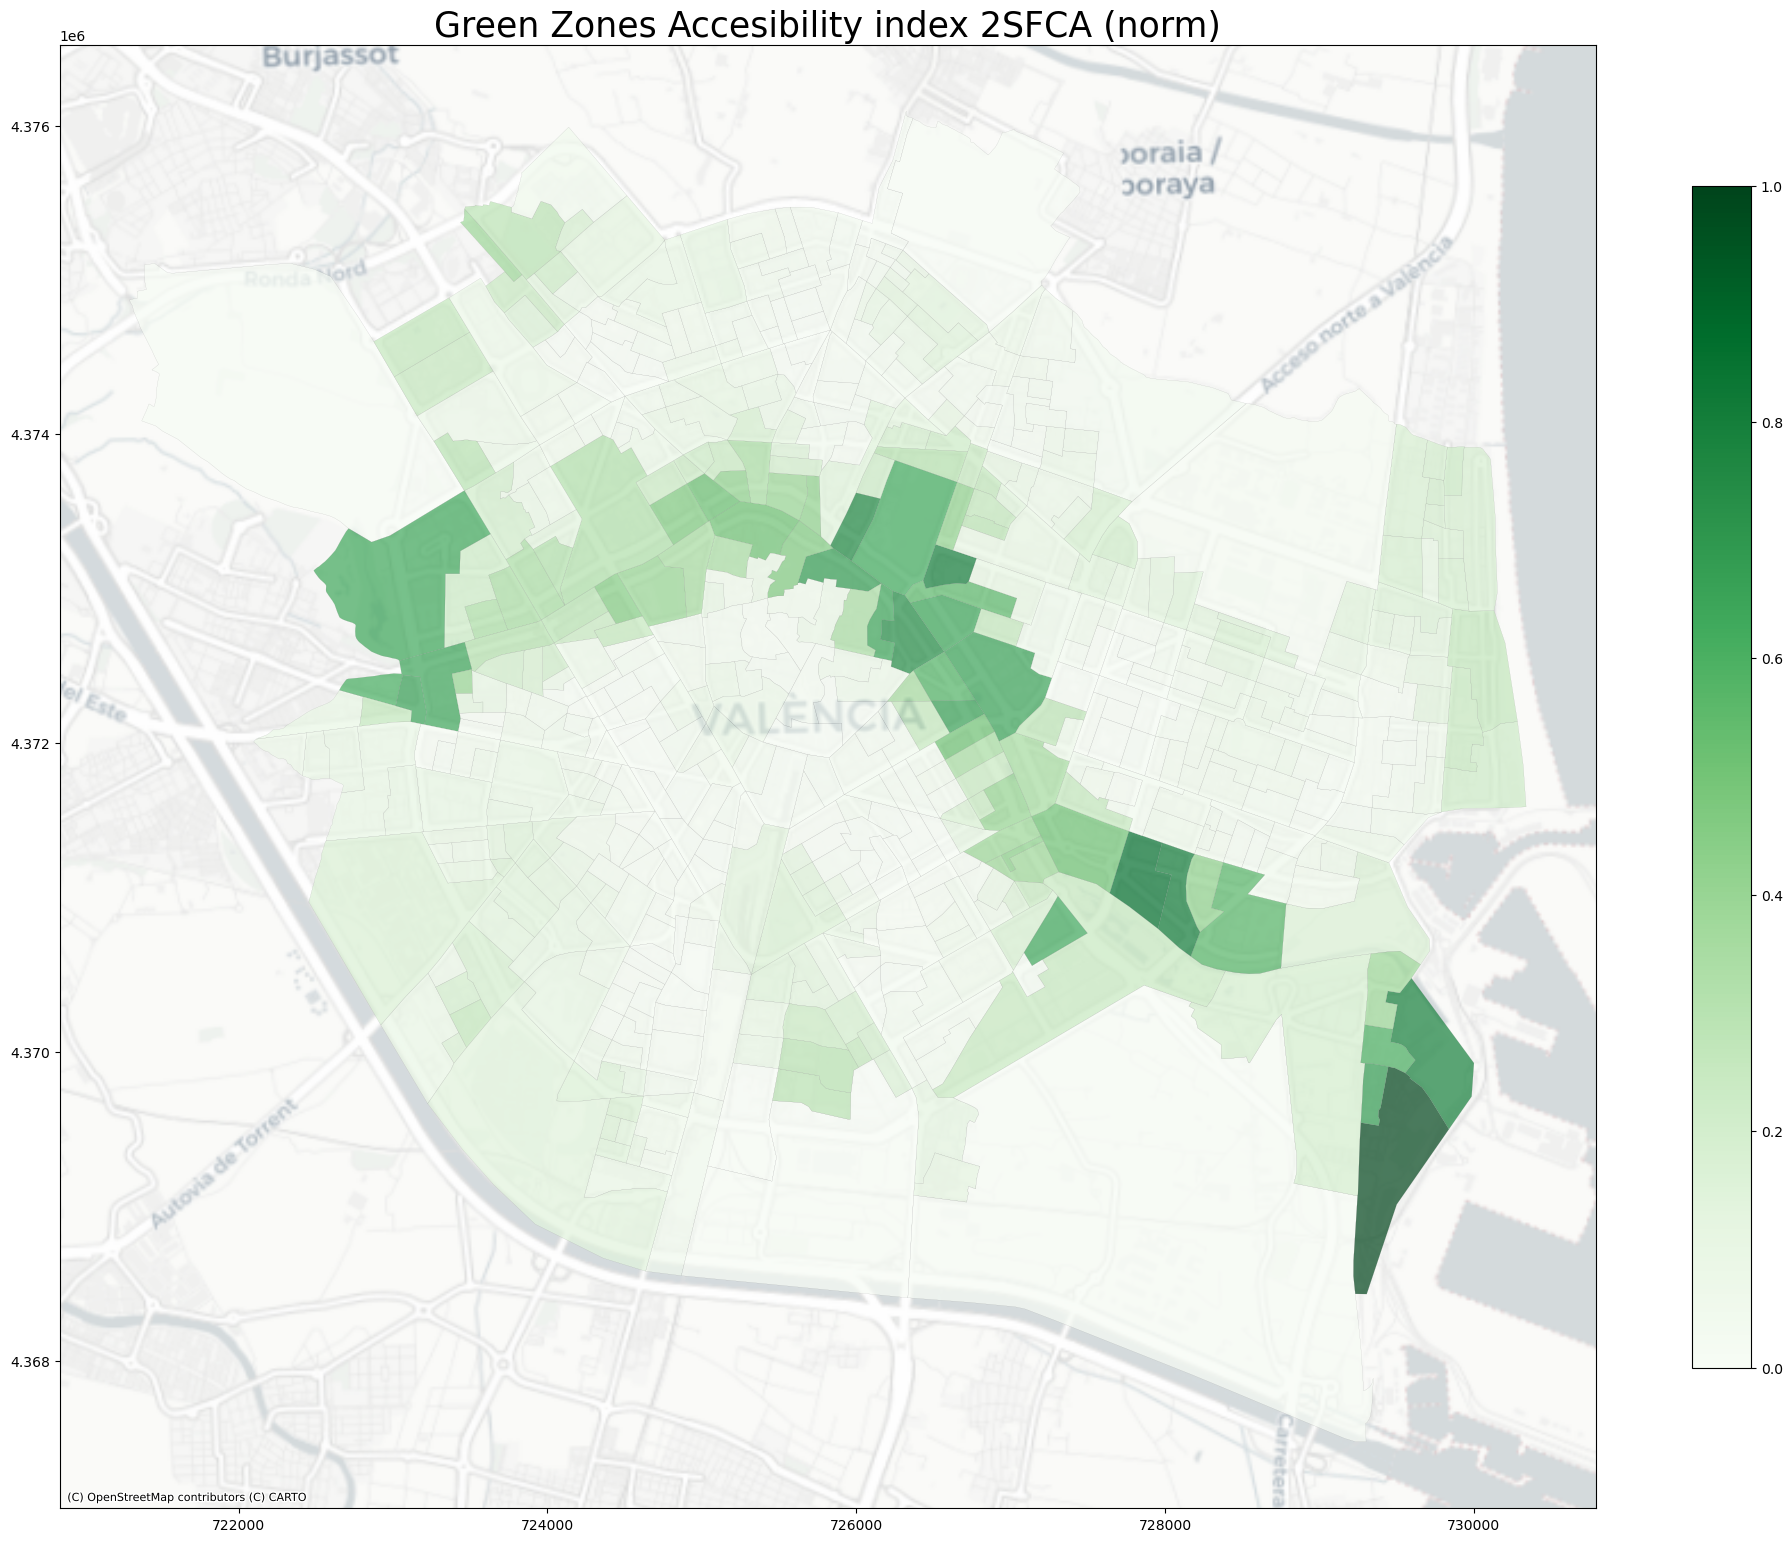

In [34]:
# Plot Accesibility Normalized
fig, ax = plt.subplots(figsize=(20,20))

census_tracts.plot(
    column='acces_norm', cmap='Greens', alpha=0.7, 
    edgecolor='grey', linewidth = 0.1, ax=ax, 
    legend=True, legend_kwds={'shrink': 0.6})
ctx.add_basemap(ax, crs=census_tracts.crs, source=ctx.providers.CartoDB.Positron)
plt.title("Green Zones Accesibility index 2SFCA (norm)", size = 25)

plt.tight_layout()
plt.show()

# Spatial Data Analysis

In this section, I employ various spatial data techniques to further explore green area accessibility. The analysis utilizes spatial statistical methods to quantify and visualize spatial autocorrelation between census tracts regarding accessibility to green zones.

## 1. **Global Spatial Correlation Analysis**
I assess the similarity of values across different spatial points, noting that positive spatial correlation indicates that similar values are located near each other, while negative spatial autocorrelation suggests similar values are dispersed.

I represent this analysis using a choropleth map, which categorizes accessibility levels using the Fisher-Jenks classification method with $ k=5 $ This approach balances the complexity of the map with the representation of significant data variations.

**Construction of Spatial Weights**

To understand the spatial structure and patterns of the city, I define the connectivity between units using a kernel function, which determines relationships based on proximity. The adaptive kernel weights adjust to local density, ensuring each census tract has a fixed number of neighbors, enhancing the analysis of spatial connections.

Upon observing that the sections have a range of 1 to 16 neighbors, with a mode of 7 neighbors, I decided to choose maximum of $k=16$ neighbors to adequately capture this diversity.

The underlying principle is that closer points have a stronger connection than those farther away. The triangular function used assigns weights that decrease linearly with distance from the focal point.

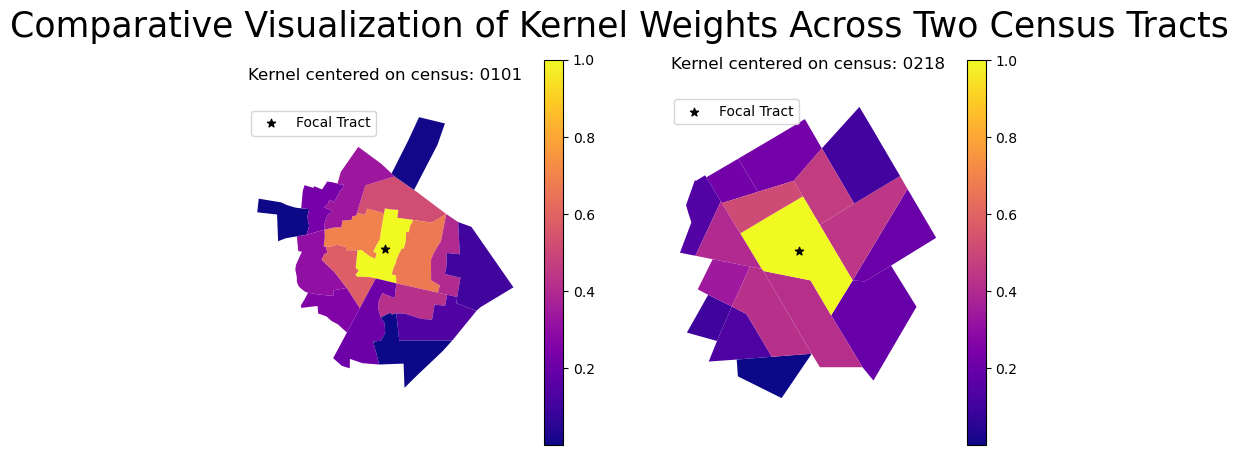

In [42]:
from pysal.lib import weights

# Construct Weight matrix based on Kernel function
w = weights.distance.Kernel.from_dataframe(census_tracts, fixed=False, k=16) # I chose a maximum of k=16 neighbors to capture the full range of variability, as sections have between 1 and 16 neighbors, with a mode of 7. 
w.bandwidth[:5]

# Plot weights
f, ax = plt.subplots(
    1,2, figsize = (10,5), subplot_kw=dict(aspect="equal")
    )
census_tracts.assign(w_0=w[0]).plot(
    "w_0", cmap='plasma', ax=ax[0], legend=True) # Append weights on 0 census and plot

census_tracts.assign(w_100 = w[100]).plot(
    "w_100", cmap='plasma', ax=ax[1], legend=True)

census_tracts.iloc[[0], :].centroid.plot(
    ax=ax[0], marker = "*", color='k', label="Focal Tract")

census_tracts.iloc[[100], :].centroid.plot(
    ax=ax[1], marker = "*", color = 'k', label = "Focal Tract")

ax[0].set_title(f"Kernel centered on census: {census_tracts.iloc[0]['coddistsecc']}")
ax[1].set_title(f"Kernel centered on census: {census_tracts.iloc[35]['coddistsecc']}")

[ax_.set_axis_off() for ax_ in ax]
[ax_.legend(loc='upper left') for ax_ in ax]

plt.suptitle("Comparative Visualization of Kernel Weights Across Two Census Tracts", fontsize = 25)
plt.show()

**Spatial Lag Model**

The direct application of the weights matrix is a spatial lag model. Spatial Lag helps understand how the values of a variable, such as 2SFCA (Two-Step Floating Catchment Area),
in one section are influenced by the values in neighboring sections. It effectively captures the spatial dependence, revealing how accessibility to green areas in one location is shaped by the surrounding areas, acting as a local "smoother" of the variable across the spatial context. 

$$Y_{sl}=W*Y$$

On the left, the map illustrates direct accessibility within each section, while the map on the right shows the spatial lag. This spatial lag indicates how accessibility in one section impacts neighboring areas. By smoothing out the differences between sections, we can see that areas with low accessibility might experience improvements due to the influence of adjacent, more accessible sections, and vice versa.

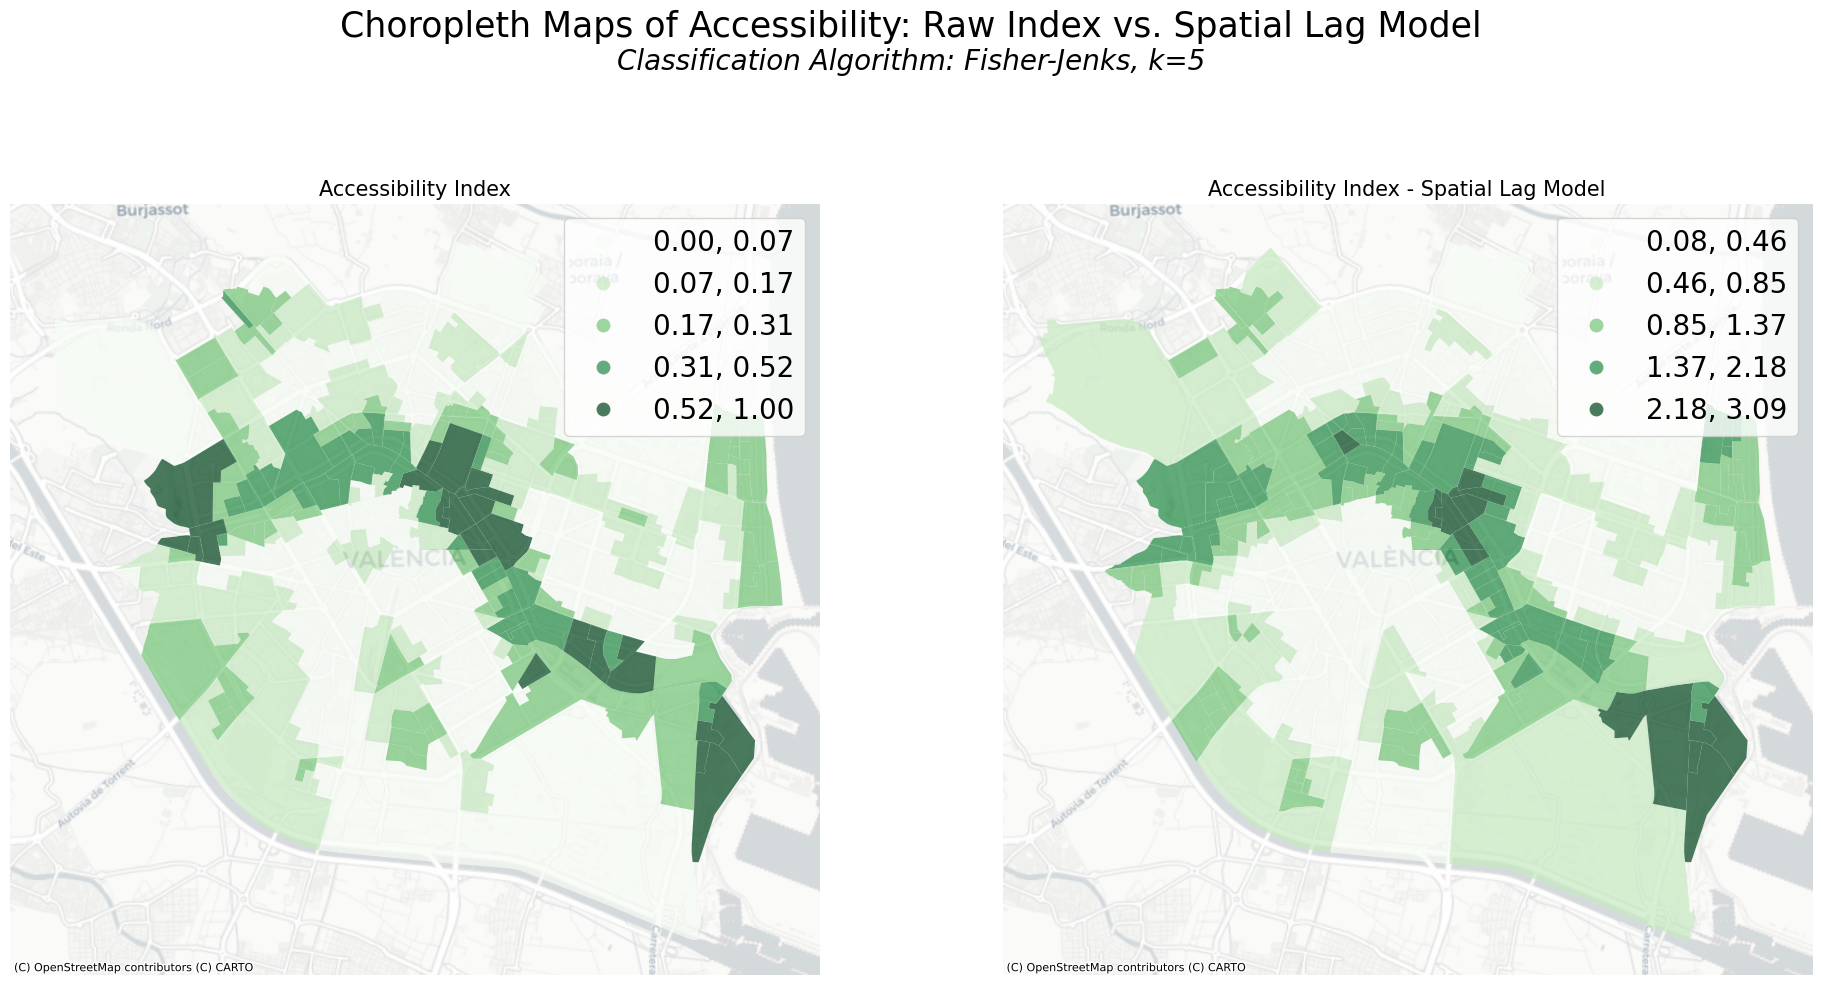

In [45]:
# Global Spatial Correlation

## Spatial Lag model
census_tracts['acces_lag'] = weights.spatial_lag.lag_spatial(w, census_tracts['acces_norm'])

# Choroplet map: Accesibility vs Accesibilty_Spatial Lag
'''Four classification methods were tested: Equal Intervals, Quantiles, Fisher-Jenks, and Jenks-Caspall. 
Ultimately, 𝑘=5 was selected for the Fisher-Jenks method as it struck the best balance between map complexity 
and the representation of significant data variations. The method's lowest ADCM score further indicated that 
it provided the most compact and accurate data classification.'''

f, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the index
census_tracts.plot(
    column='acces_norm',
    cmap='Greens',
    scheme='FisherJenks',
    k=5,
    edgecolor='white',
    linewidth=0.05,
    alpha=0.7,
    legend=True,
    ax=ax[0],
    legend_kwds={'fontsize': 20}
)

ctx.add_basemap(ax[0], crs=census_tracts.crs, source=ctx.providers.CartoDB.Positron)
ax[0].set_axis_off()
ax[0].set_title("Accessibility Index", size=15)

# Plot the spatial lag
census_tracts.plot(
    column='acces_lag',
    cmap='Greens',
    scheme='FisherJenks',
    k=5,
    edgecolor='white',
    linewidth=0.05,
    alpha=0.7,
    legend=True,
    ax=ax[1],
    legend_kwds={'fontsize': 20}
)

ctx.add_basemap(ax[1], crs=census_tracts.crs, source=ctx.providers.CartoDB.Positron)
ax[1].set_axis_off()
ax[1].set_title("Accessibility Index - Spatial Lag Model", size=15)

# Set the main title
plt.suptitle("Choropleth Maps of Accessibility: Raw Index vs. Spatial Lag Model", fontsize=25)

# Set the subtitle
plt.figtext(0.5, 0.92, "Classification Algorithm: Fisher-Jenks, k=5", ha='center', fontsize=20, fontstyle='italic')

# Adjust layout to prevent overlap
plt.subplots_adjust(top=0.85)
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

**Moran's I**

To interpret the geographic patterns observed in the maps and minimize potential errors, I employed the Moran statistic. This statistic helps assess the significance of spatial patterns, indicating whether nearby locations exhibit similar values for green zone accessibility.

The Moran Plot visually represents this relationship by plotting standardized values against their spatial lag, helping to identify clusters or patterns of similarity in accessibility across different regions. My analysis yielded a Moran's I value of 0.60, indicating moderate to strong positive spatial autocorrelation. This suggests that areas with high accessibility to green zones are likely clustered together, as are areas with low accessibility. The p-value of 0.001 confirms that this observed spatial autocorrelation is statistically significant, indicating that the pattern is a real spatial phenomenon rather than random variation.

Moran´s I statistics



Moran´s I  p-value
0   0.602084    0.001

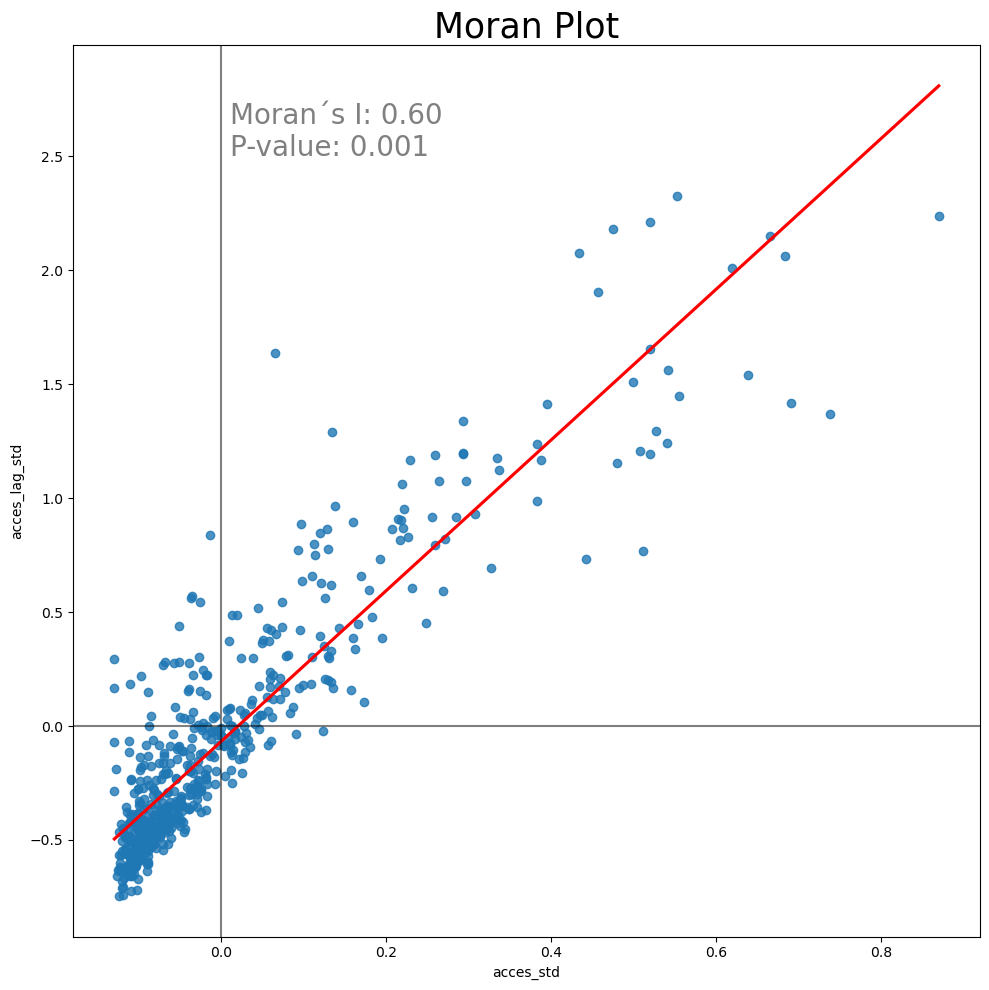

In [48]:
# Moran´s I
census_tracts['acces_std'] = census_tracts['acces_norm'] - census_tracts['acces_norm'].mean()
census_tracts['acces_lag_std'] = weights.lag_spatial(w, census_tracts['acces_std'])
mi_acces = esda.moran.Moran(census_tracts['acces_norm'], w)

resume_moran = pd.DataFrame({
    "Moran´s I" : [mi_acces.I],
    "p-value" : [mi_acces.p_sim.mean()]
    })
print(f"Moran´s I statistics\n")
display(resume_moran)

# Moran Plot
fig, ax = plt.subplots(figsize = (10,10))
sns.regplot(
    x = 'acces_std',
    y = 'acces_lag_std',
    ci = None,
    data = census_tracts,
    line_kws={"color": "r"},
    ax=ax)
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c = "k", alpha = 0.5)

plt.text(0.01, 2.5,
         f"Moran´s I: {mi_acces.I:,.2f}\n"
         f"P-value: {mi_acces.p_sim.mean()}", size = 20, c='grey')

plt.title("Moran Plot", size = 25)

plt.tight_layout()
plt.show()

## 2. **Local Spatial Correlation Analysis**
While the global Moran's index provides an overall tendency of clustering, it doesn’t specify the locations of high or low-value clusters. To pinpoint these clusters, I utilized the local Moran's index. This approach reflects autocorrelation across different areas, generating multiple values for various locations. Each section is categorized into quadrants (High-High, Low-Low, High-Low, Low-High) with statistical significance evaluated (p_sim < 0.05). The resulting data is visualized on a color-coded map.

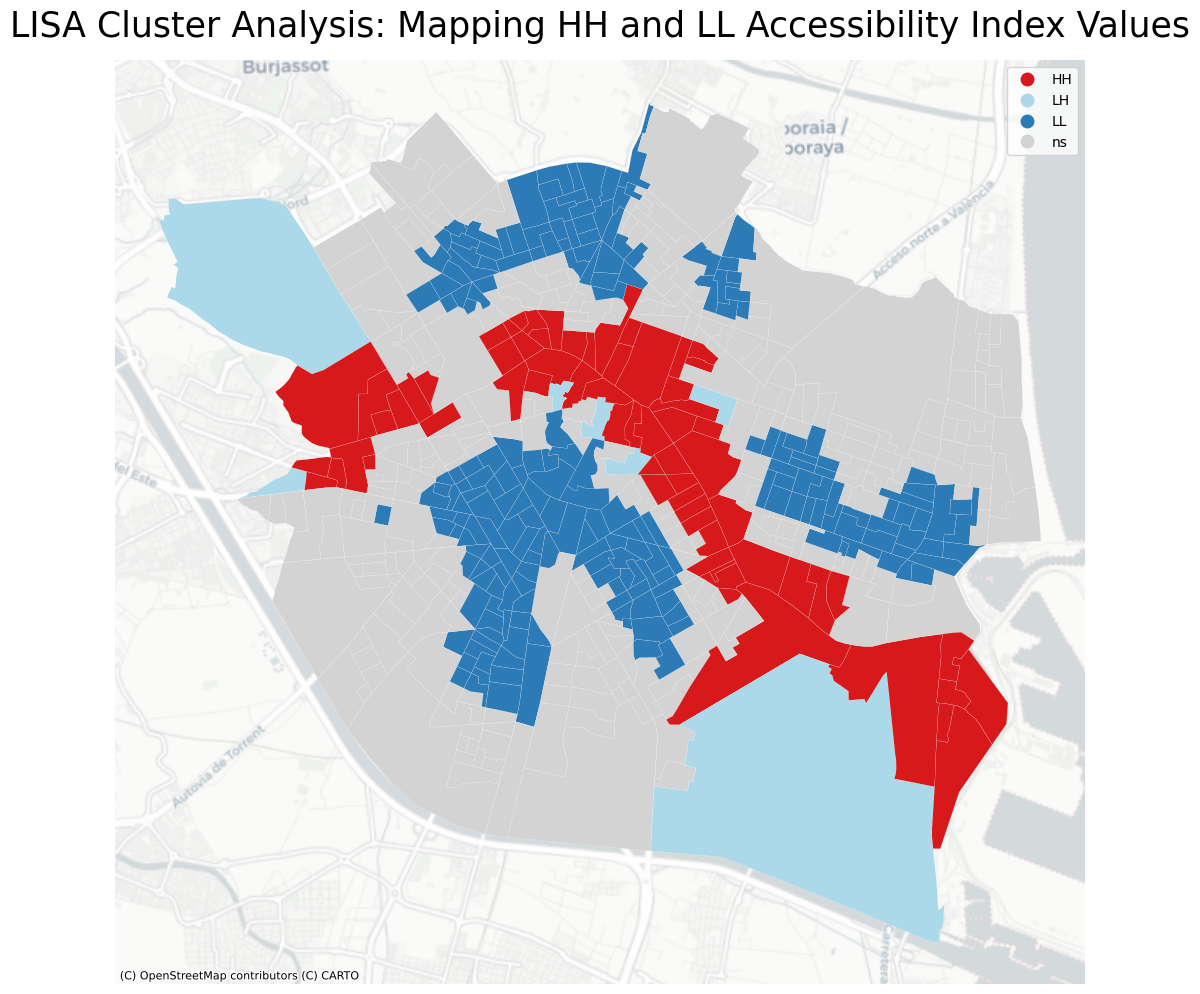

Number of observations in each cluster: 



3    354
1    140
2     36
4     30
Name: count, dtype: int64

In [51]:
# Local Spatial Correlation
lisa = esda.moran.Moran_Local(census_tracts['acces_norm'], w)

fig, ax = plt.subplots(figsize = (10,10))
esdaplot.lisa_cluster(lisa, census_tracts, p = 0.05, ax=ax)
ctx.add_basemap(ax, crs=census_tracts.crs, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("LISA Cluster Analysis: Mapping HH and LL Accessibility Index Values", size =25)

plt.tight_layout()
plt.show()

counts = pd.Series(lisa.q).value_counts()

print("Number of observations in each cluster: \n")
display(counts)

# Export significance levels
census_tracts['p_sim_acces'] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
census_tracts['sign_dummy'] = sig
# Labels from value
spots_labels = {
    0: "NS",
    1: "HH",
    2: "LH",
    3: "LL"
    }
spots = lisa.q * sig # Pick as part of a quadrant only significant polygons, assign `0` otherwise (Non-significant polygons)
census_tracts['local_labels'] = pd.Series(
    spots, index=census_tracts.index # initialise a Series using values and `db` index
    ).map(spots_labels) # map each value to corresponding label based on the `spots_labels` mapping

The results indicate a statistically significant spatial clustering of accessibility to green zones within the city.

The LISA cluster maps highlight specific areas of clustering, showing that high-accessibility clusters are concentrated around the central river park, while low-accessibility clusters appear predominantly in the northern and southern parts of the city.

# Key Findings and Insights

1. **Data Sources and Methodology:**
 - My analysis leveraged census and demographic data from the Instituto Nacional de Estadística and geospatial data from the Geo Portal del Ayuntamiento de Valencia.
 - The project involved multiple stages: exploratory analysis, accessibility analysis using the 2SFCA method, and spatial autocorrelation analysis to identify patterns in green space distribution.

2. **Green Coverage and Accessibility:**
 - I assessed the per capita availability of green space, uncovering high population density areas in need of additional green zones.
 - The 2SFCA method was employed to measure accessibility, considering distances, green zone sizes, and the population within a 500-meter catchment area. This analysis highlighted disparities in green space accessibility across the city.

3. **Spatial Autocorrelation:**
 - I identified hot spots and cold spots of green coverage, indicating clusters of census tracts with high or low availability.

4. **Green Area Calculations:**
 - The total area of green zones was categorized, revealing that urban parks constitute the largest portion at 223.32 ha, while smaller areas like protected gardens and Jardines Barrio Plaza cover 37.08 ha and 123.56 ha, respectively.
 - Overall green coverage in Valencia was calculated at 7.82%, suggesting room for improvement in urban planning to enhance green space availability.

5. **Disparities in Accessibility:**
   
Accessibility to green spaces varied significantly among different city zones:
 - Zone Norte: 7.51 sqm green space per person (below minimum recommendations).
 - Zone Sur: 6.17 sqm green space per person (also below minimum).
 - River Park Turia: 61.24 sqm green space per person (exceeding ideal recommendations).

These findings highlight the urgent need to enhance green infrastructure in Zones Norte and Sur to meet global standards.

6. **District-Level Analysis:**

- Analyzing data by administrative districts revealed significant disparities, particularly in districts like Rascanya and Benimaclet, where access to green spaces was notably low, emphasizing the necessity for targeted interventions.

7. **Accessibility Index:**
 - The accessibility index, calculated through the 2SFCA method, revealed variations in access to green zones. Utilizing distance-decay functions offered a nuanced view of accessibility, underscoring the importance of proximity to green spaces.

8. **Visualization and Mapping:**
 - I visualized the accessibility index using choropleth maps and the Fisher-Jenks classification method to effectively represent the data. The color gradient illustrated the contrast between areas with low and high accessibility.

9. **Kernel Function for Spatial Weights:**
 - A kernel function was utilized to establish relationships between census tracts based on proximity, allowing for adaptive kernel weights that adjust to local density and reveal insights into spatial connections.

# Conclusion
This analysis of green zone accessibility in Valencia uncovers significant disparities in both the availability and accessibility of green spaces throughout the city. The findings emphasize the need for strategic urban planning and investment in green infrastructure, particularly in underserved areas. By addressing these disparities, we can improve residents' quality of life and align our urban development with sustainability goals. Further spatial analysis will enhance our understanding of accessibility dynamics and inform policy interventions.

# Limitations
While this analysis provides valuable insights, there are some limitations to consider:
 - Use of Centroids for Distance Calculations: Calculating distances between census tracts and green zones using centroids introduces inaccuracies, particularly in areas with irregularly shaped or large sections. This is because centroids do not reflect the true distribution of population within a section. A more refined method, such as calculating distances from multiple points within a section, would provide a more precise measure of accessibility.
 - Distance Measurement Approach: While the Manhattan distance metric was used to account for the grid-like street layout in Valencia, it may not be the optimal method for all areas. A more advanced approach, such as Dijkstra's algorithm, which takes into account real street networks and barriers, would improve the accuracy of accessibility calculations by reflecting more realistic travel paths.
 - Proximity-Based Spatial Weights: The spatial autocorrelation analysis relies on proximity to define relationships between census tracts. This approach may miss important socio-demographic factors that also affect accessibility, such as income levels, population density, or age distribution. Incorporating these variables could provide a more comprehensive view of accessibility patterns.
 - Exclusion of Rural Districts: The exclusion of rural districts from the analysis limits its applicability to the broader region. While this focus on urban areas is justifiable, it may skew our understanding of green space accessibility, particularly in the context of larger urban-rural dynamics.

# Future Investigation
 - Future investigations could build on this analysis by incorporating qualitative assessments of green spaces, such as user surveys to evaluate perceived accessibility and satisfaction. Including more granular socio-economic data would also be beneficial to explore correlations between green zone accessibility and factors like income or education levels across spatial clusters. 

 - Additionally, testing whether areas with lower accessibility to green zones experience poorer health outcomes, such as higher rates of chronic diseases or lower life expectancy, would provide further insights. 

 - Lastly, incorporating advanced spatial modeling techniques, such as geographically weighted regression (GWR), could enhance our understanding of localized factors influencing green space accessibility in different neighborhoods.